In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

In [22]:
class STLData(Dataset):
    def __init__(self,trn_val_tst = 0, transform=None):
        data = np.load('hw3.npz')
        if trn_val_tst == 0:
            #trainloader
            self.images = data['arr_0']
            self.labels = data['arr_1']
        elif trn_val_tst == 1:
            #valloader
            self.images = data['arr_2']
            self.labels = data['arr_3']
        else:
            #testloader
            self.images = data['arr_4']
            self.labels = data['arr_5']
            
        self.images = np.float32(self.images)/1.0
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
   
        sample = self.images[idx,:]
        labels = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, labels

In [223]:
train_set = STLData(trn_val_tst=0, transform=torchvision.transforms.ToTensor()) 
val_set = STLData(trn_val_tst=1, transform=torchvision.transforms.ToTensor()) 
test_set = STLData(trn_val_tst=2, transform=torchvision.transforms.ToTensor()) 

In [244]:
batch_size = 100
n_workers = multiprocessing.cpu_count()
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

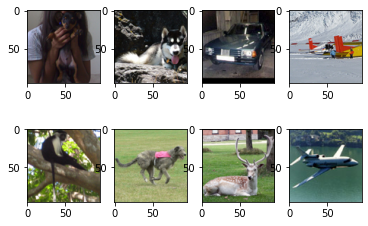

In [245]:
image_batch, labels = next(iter(trainloader))
for tmpC1 in range(8):    
    img = np.moveaxis(image_batch[tmpC1].numpy(),0,2)
    plt.subplot(2,4,tmpC1+1)
    plt.imshow(img/255.0)

In [156]:
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

In [246]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3,96,(7,7),stride=2)
        self.conv2 = nn.Conv2d(96,64,(5,5),stride=2)
        self.conv3 = nn.Conv2d(64,128,(3,3),stride=2)
        self.pool = nn.MaxPool2d((3,3),stride=3)
        self.fc1 = nn.Linear(1152,128)
        self.fc2 = nn.Linear(128,10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1,1152)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
        

In [248]:
import torch.optim as optim

net1 = Net()
Loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(net1.parameters(), lr=0.001)
trainLoss_save = []
valLoss_save = []
trainAcc_save = []
valAcc_save = []
testAcc_save = []

for epoch in range(60):  # loop over the dataset multiple times
    print('epoch {}'.format(epoch + 1))
    train_loss = 0.
    train_acc = 0.
    val_loss = 0.
    val_acc = 0.
    for i, data in enumerate(trainloader):
        img, label = data
        label=torch.tensor(label, dtype=torch.long) 
        optimizer.zero_grad()
        out = net1(img)
        loss = Loss(out, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pre = torch.max(out, 1)[1]
        train_correct = (pre.cpu() == label.cpu()).sum()
        train_acc += train_correct.item()
        if i == len(trainloader) - 1:
            trainLoss_save.append(train_loss / len(trainloader)) # need
            trainAcc_save.append((train_acc / len(trainloader))) # need
            print('train loss= ', train_loss / len(trainloader))
            print('train acc= ', train_acc / len(trainloader))
            train_loss = 0.
            train_acc = 0.
    with torch.no_grad():
        correct = 0
        for i, val_data in enumerate(valloader):
            val_img, val_label = val_data
            #val_label = val_label.squeeze(1)
            val_label = val_label.long()
            images, labels = val_img, val_label
            outputs = net1(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum()
            loss = Loss(outputs, labels)
            val_loss += loss.item()
    valAcc_save.append(correct/len(valloader)) # need   
    valLoss_save.append(val_loss / len(valloader))

    with torch.no_grad():
        correct = 0
        for i, test_data in enumerate(testloader):
            test_img, test_label = test_data
            #test_label = test_label.squeeze(1)
            test_label = test_label.long()
            images, labels = test_img, test_label
            outputs = net1(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum()
    testAcc_save.append(correct / len(testloader)) # need
    # torch.save(model.state_dict(), '_model.pkl')
print('Finished Training')

epoch 1


<ipython-input-248-34dfc7bac726>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label=torch.tensor(label, dtype=torch.long)


train loss=  2.2590245842933654
train acc=  15.6875
epoch 2
train loss=  2.2159476399421694
train acc=  20.025
epoch 3
train loss=  2.1023514360189437
train acc=  25.5625
epoch 4
train loss=  2.044347968697548
train acc=  28.3
epoch 5
train loss=  1.9716331109404563
train acc=  30.1625
epoch 6
train loss=  1.90297924131155
train acc=  33.0875
epoch 7
train loss=  1.8377709895372392
train acc=  36.025
epoch 8
train loss=  1.7609037846326827
train acc=  38.8125
epoch 9
train loss=  1.70180584192276
train acc=  41.1
epoch 10
train loss=  1.6491501480340958
train acc=  42.825
epoch 11
train loss=  1.610242022573948
train acc=  44.4125
epoch 12
train loss=  1.5815613508224486
train acc=  45.325
epoch 13
train loss=  1.538369169831276
train acc=  47.425
epoch 14
train loss=  1.4624279350042344
train acc=  48.575
epoch 15
train loss=  1.3582710102200508
train acc=  52.475
epoch 16
train loss=  1.3091235280036926
train acc=  53.85
epoch 17
train loss=  1.273632103204727
train acc=  55.2875
epo

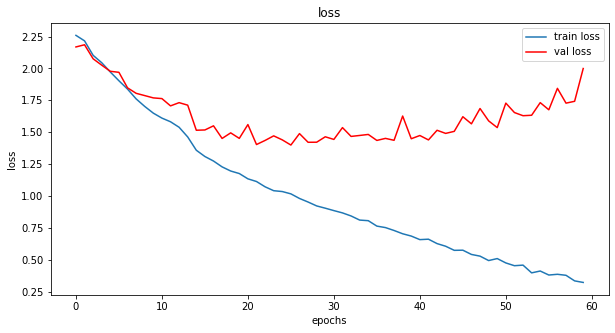

In [249]:

x = range(60)

plt.figure(figsize=(10,5))
plt.title("loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(x,trainLoss_save,'-',label="train loss")
plt.plot(x,valLoss_save,'-',color='r',label="val loss")
plt.legend()


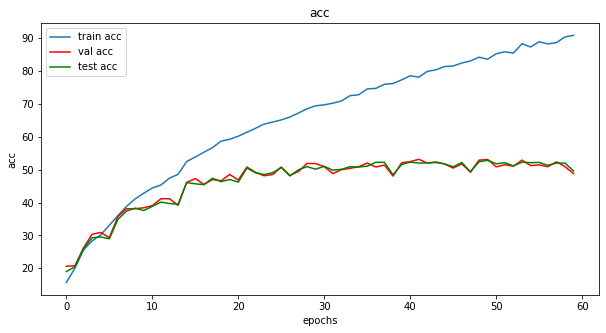

In [250]:
import numpy as np
plt.figure(figsize=(10,5))
plt.title("acc")
plt.xlabel("epochs")
plt.ylabel("acc")

plt.plot(x,trainAcc_save,'-',label="train acc")
plt.plot(x,valAcc_save,'-',color='r',label="val acc")
plt.plot(x,testAcc_save,'-',color='g',label="test acc")
plt.legend()

[118  22  45  21  40]
[ 8 58 14 28 44]
[117 135  21 142 118]
[33 18  9 15 38]
[ 2 21  5 17 22]
[ 8  3 26  0 37]
[ 13  94 123  60 113]
[10 46 40 12 21]
[  7 115  97  59  47]
[ 27 103  56  39  20]


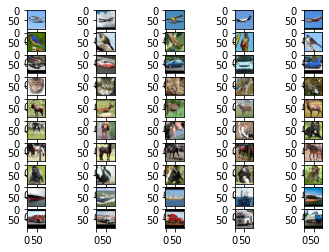

In [278]:
c = [[] for _ in range(10)]
im = [[] for _ in range(10)]
for i, val_data in enumerate(valloader):
    val_img, val_label = val_data
    val_label = val_label.long()
    images, labels = val_img, val_label
    outputs = net1(images)
    score, predicted = torch.max(outputs, 1)
    for x in range(len(predicted)):
        if predicted[x] == labels[x]:
            c[labels[x].item()].append(score[x])
            im[labels[x].item()].append(images[x])


for i in range(10):
    arr = np.array(c[i])
    top_k_idx=arr.argsort()[::-1][0:5]
    print(top_k_idx)
    for x in range(len(top_k_idx)):
        plt.subplot(10,5,5*i+x+1)
        img = np.moveaxis(im[i][top_k_idx[x]].numpy(),0,2)
        plt.imshow(img/255)
    



[ 6 43 24 23 31]
[108  16  34 107  66]
[29 42 32 19 24]
[ 33 111  21  25 147]
[135 146  66  77  65]
[ 79 147 125 141  28]
[13 12 38  4 23]
[  0   9  82  57 103]
[44 49 51 68 55]
[21 26 16 23 12]


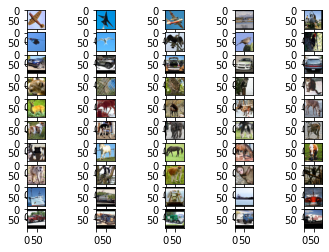

In [279]:
c1 = [[] for _ in range(10)]
im1 = [[] for _ in range(10)]
for i, val_data in enumerate(valloader):
    val_img, val_label = val_data
    val_label = val_label.long()
    images, labels = val_img, val_label
    outputs = net1(images)
    score, predicted = torch.max(outputs, 1)
    for x in range(len(predicted)):
        if predicted[x] != labels[x]:
            c1[labels[x].item()].append(score[x])
            im1[labels[x].item()].append(images[x])


for i in range(10):
    arr = np.array(c1[i])
    top_k_idx=arr.argsort()[::-1][0:5]
    print(top_k_idx)
    for x in range(len(top_k_idx)):
        plt.subplot(10,5,5*i+x+1)
        img = np.moveaxis(im1[i][top_k_idx[x]].numpy(),0,2)
        plt.imshow(img/255)
    

In [253]:
val = np.zeros((10,10))
train = np.zeros((10,10))
test = np.zeros((10,10))
for i, train_data in enumerate(trainloader):
    train_img, train_label = train_data
    train_label = train_label.long()
    images, labels = train_img, train_label
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    for x in range(len(predicted)):
         train[predicted[x]][labels[x]] +=1
            
for i, val_data in enumerate(valloader):
    val_img, val_label = val_data
    val_label = val_label.long()
    images, labels = val_img, val_label
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    for x in range(len(predicted)):
         val[predicted[x]][labels[x]] +=1

for i, test_data in enumerate(testloader):
    test_img, test_label = test_data
    test_label = test_label.long()
    images, labels = test_img, test_label
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    for x in range(len(predicted)):
         test[predicted[x]][labels[x]] +=1

print('train confusion matrix')
print(train)
print('val confusion matrix')
print(val)
print('test confusion matrix')
print(test)            

train confusion matrix
[[714.   4.  27.   0.   0.   0.   0.   0.  44.  27.]
 [ 19. 464.   4.   2.   1.   4.   1.   1.   5.   7.]
 [  4.   0. 715.   0.   0.   0.   0.   0.   9. 175.]
 [  9. 150.  26. 682.  69. 148.  24.  75.  27.  59.]
 [ 15.  25.   8.  54. 709.  81. 124.  25.   9.  20.]
 [  5.  28.   6.  18.   7. 438. 101.   8.   5.  13.]
 [  2.   0.   6.   0.   2.   5. 496.   2.   0.  42.]
 [  3. 127.   2.  44.  12. 123.  54. 689.   3.   4.]
 [ 29.   2.   6.   0.   0.   1.   0.   0. 698.  29.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. 424.]]
val confusion matrix
[[158.   8.   6.   0.   0.   0.   2.   0.  21.  15.]
 [  7.  84.   3.   2.   1.   5.   0.   6.   7.   2.]
 [  2.   0. 169.   1.   0.   0.   1.   0.   8.  53.]
 [  3.  40.   5. 120.  48.  50.   8.  34.  10.  22.]
 [  7.  14.   3.  25. 137.  22.  39.   7.   4.   7.]
 [  1.  11.   3.  23.   7.  63.  35.  11.   3.   0.]
 [  2.   0.   6.   0.   3.   9.  95.   4.   1.  14.]
 [  3.  29.   1.  28.  13.  52.  21. 140.   1.   4.]
 

In [149]:
class conv_blk(nn.Module):
    def __init__(self,ci,co):
        super(conv_blk,self).__init__()
        self.conv1 = nn.Conv2d(ci,co,(3,3),stride=2,padding=1)
        self.conv2 = nn.Conv2d(co,co,(1,1),stride=1)
        self.conv3 = nn.Conv2d(co,co,(3,3),stride=1,padding=1)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x

class deep_cnn(nn.Module):
    def __init__(self):
        super(deep_cnn,self).__init__()
        self.conv_blk1 = conv_blk(3,32)
        self.conv_blk2 = conv_blk(32,64)
        self.conv_blk3 = conv_blk(64,128)
        self.conv_blk4 = conv_blk(128,192)
        self.fc = nn.Linear(192,10)
    def forward(self, x):
        x = self.conv_blk1(x)
        x = self.conv_blk2(x)
        x = self.conv_blk3(x)
        x = self.conv_blk4(x)
        x = F.adaptive_avg_pool2d(x,(1,1))
        x = x.view(-1,192)
        x = self.fc(x)
        
        return x


In [157]:
import torch.optim as optim

net = deep_cnn()
Loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
trainLoss_save = []
valLoss_save = []
trainAcc_save = []
valAcc_save = []
testAcc_save = []

for epoch in range(40):  # loop over the dataset multiple times
    print('epoch {}'.format(epoch + 1))
    train_loss = 0.
    train_acc = 0.
    val_loss = 0.
    val_acc = 0.
    for i, data in enumerate(trainloader):
        img, label = data
        label=torch.tensor(label, dtype=torch.long) 
        optimizer.zero_grad()
        out = net(img)
        loss = Loss(out, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pre = torch.max(out, 1)[1]
        train_correct = (pre.cpu() == label.cpu()).sum()
        train_acc += train_correct.item()
        if i == len(trainloader) - 1:
            trainLoss_save.append(train_loss / len(trainloader)) # need
            trainAcc_save.append((train_acc / len(trainloader))) # need
            print('train loss= ', train_loss / len(trainloader))
            print('train acc= ', train_acc / len(trainloader))
            train_loss = 0.
            train_acc = 0.
    with torch.no_grad():
        correct = 0
        for i, val_data in enumerate(valloader):
            val_img, val_label = val_data
            #val_label = val_label.squeeze(1)
            val_label = val_label.long()
            images, labels = val_img, val_label
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum()
            loss = Loss(outputs, labels)
            val_loss += loss.item()
    print('val loss= ', val_loss / len(valloader))
    print('val acc= ', correct / len(valloader))
    valAcc_save.append(correct/len(valloader)) # need   
    valLoss_save.append(val_loss / len(valloader))

    with torch.no_grad():
        correct = 0
        for i, test_data in enumerate(testloader):
            test_img, test_label = test_data
            #test_label = test_label.squeeze(1)
            test_label = test_label.long()
            images, labels = test_img, test_label
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum()
    testAcc_save.append(correct / len(testloader)) # need
    # torch.save(model.state_dict(), '_model.pkl')
print('Finished Training')

epoch 1


<ipython-input-157-d79996085dc8>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label=torch.tensor(label, dtype=torch.long)


train loss=  2.191463640332222
train acc=  14.875
val loss=  2.0170533418655396
val acc=  tensor(19.7000)
epoch 2
train loss=  1.8564931124448776
train acc=  22.05
val loss=  1.8021098613739013
val acc=  tensor(23.8000)
epoch 3
train loss=  1.768259224295616
train acc=  26.2875
val loss=  1.7076287508010863
val acc=  tensor(28.9500)
epoch 4
train loss=  1.6461355835199356
train acc=  33.3
val loss=  1.5870694518089294
val acc=  tensor(35.7000)
epoch 5
train loss=  1.5341895341873169
train acc=  38.7625
val loss=  1.5262998402118684
val acc=  tensor(41.0500)
epoch 6
train loss=  1.459746965765953
train acc=  41.975
val loss=  1.4812157332897187
val acc=  tensor(43.9000)
epoch 7
train loss=  1.4178478226065636
train acc=  43.6125
val loss=  1.4866580247879029
val acc=  tensor(43.2000)
epoch 8
train loss=  1.3660640224814415
train acc=  47.025
val loss=  1.475036883354187
val acc=  tensor(42.)
epoch 9
train loss=  1.311192137002945
train acc=  48.85
val loss=  1.3980443120002746
val acc= 

In [204]:
import torchvision.transforms as transforms


transform2 = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5), #random Horizontal flip with 50% chance
            
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.5),#Randomly zero sections of the image with 50% chance
           
            
            ]) 

In [205]:
train_set = STLData(trn_val_tst=0, transform=transform2) 
val_set = STLData(trn_val_tst=1, transform=transform2) 
test_set = STLData(trn_val_tst=2, transform=torchvision.transforms.ToTensor()) 

batch_size = 100
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=True, num_workers=0)



In [206]:
net = deep_cnn()
Loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
trainLoss_save = []
valLoss_save = []
trainAcc_save = []
valAcc_save = []
testAcc_save = []

for epoch in range(40):  # loop over the dataset multiple times
    print('epoch {}'.format(epoch + 1))
    train_loss = 0.
    train_acc = 0.
    val_loss = 0.
    val_acc = 0.
    for i, data in enumerate(trainloader):
        img, label = data
        label=torch.tensor(label, dtype=torch.long) 
        optimizer.zero_grad()
        out = net(img)
        loss = Loss(out, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pre = torch.max(out, 1)[1]
        train_correct = (pre.cpu() == label.cpu()).sum()
        train_acc += train_correct.item()
        if i == len(trainloader) - 1:
            trainLoss_save.append(train_loss / len(trainloader)) # need
            trainAcc_save.append((train_acc / len(trainloader))) # need
            print('train loss= ', train_loss / len(trainloader))
            print('train acc= ', train_acc / len(trainloader))
            train_loss = 0.
            train_acc = 0.
    with torch.no_grad():
        correct = 0
        for i, val_data in enumerate(valloader):
            val_img, val_label = val_data
            #val_label = val_label.squeeze(1)
            val_label = val_label.long()
            images, labels = val_img, val_label
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum()
            loss = Loss(outputs, labels)
            val_loss += loss.item()
    print('val loss= ', val_loss / len(valloader))
    print('val acc= ', correct / len(valloader))
    valAcc_save.append(correct/len(valloader)) # need   
    valLoss_save.append(val_loss / len(valloader))

    with torch.no_grad():
        correct = 0
        for i, test_data in enumerate(testloader):
            test_img, test_label = test_data
            #test_label = test_label.squeeze(1)
            test_label = test_label.long()
            images, labels = test_img, test_label
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum()
    testAcc_save.append(correct / len(testloader)) # need
    # torch.save(model.state_dict(), '_model.pkl')
print('Finished Training')

epoch 1


<ipython-input-206-5e8e721647bb>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label=torch.tensor(label, dtype=torch.long)


train loss=  2.0633287534117697
train acc=  19.725
val loss=  1.8559659779071809
val acc=  tensor(25.0500)
epoch 2
train loss=  1.7662615597248077
train acc=  29.575
val loss=  1.7309702396392823
val acc=  tensor(29.9000)
epoch 3
train loss=  1.6583733260631561
train acc=  32.9375
val loss=  1.603139990568161
val acc=  tensor(36.7000)
epoch 4
train loss=  1.6141434147953988
train acc=  35.6375
val loss=  1.6273135244846344
val acc=  tensor(37.6500)
epoch 5
train loss=  1.5572288244962693
train acc=  38.3625
val loss=  1.5227250039577485
val acc=  tensor(42.2000)
epoch 6
train loss=  1.5098681822419167
train acc=  40.625
val loss=  1.537452870607376
val acc=  tensor(38.9500)
epoch 7
train loss=  1.4611364915966987
train acc=  43.025
val loss=  1.5205755531787872
val acc=  tensor(43.4000)
epoch 8
train loss=  1.3922369807958603
train acc=  46.3875
val loss=  1.4353950142860412
val acc=  tensor(45.6000)
epoch 9
train loss=  1.344072976708412
train acc=  48.8625
val loss=  1.47824956178665

In [198]:
class conv_blk(nn.Module):
    def __init__(self,ci,co):
        super(conv_blk,self).__init__()
        self.conv1 = nn.Conv2d(ci,co,(3,3),stride=2,padding=1)
        self.conv2 = nn.Conv2d(co,co,(1,1),stride=1)
        self.conv3 = nn.Conv2d(co,co,(3,3),stride=1,padding=1)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x

class deep_cnn(nn.Module):
    def __init__(self):
        super(deep_cnn,self).__init__()
        self.conv_blk1 = conv_blk(3,32)
        self.conv_blk2 = conv_blk(32,64)
        self.conv_blk3 = conv_blk(64,128)
        
        self.fc = nn.Linear(128,10)
    def forward(self, x):
        x = self.conv_blk1(x)
        x = self.conv_blk2(x)
        x = self.conv_blk3(x)
        x = F.adaptive_avg_pool2d(x,(1,1))
        x = x.view(-1,128)
        x = self.fc(x)
        
        return x


In [199]:
import torch.optim as optim

net = deep_cnn()
Loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
trainLoss_save = []
valLoss_save = []
trainAcc_save = []
valAcc_save = []
testAcc_save = []

for epoch in range(40):  # loop over the dataset multiple times
    print('epoch {}'.format(epoch + 1))
    train_loss = 0.
    train_acc = 0.
    val_loss = 0.
    val_acc = 0.
    for i, data in enumerate(trainloader):
        img, label = data
        label=torch.tensor(label, dtype=torch.long) 
        optimizer.zero_grad()
        out = net(img)
        loss = Loss(out, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pre = torch.max(out, 1)[1]
        train_correct = (pre.cpu() == label.cpu()).sum()
        train_acc += train_correct.item()
        if i == len(trainloader) - 1:
            trainLoss_save.append(train_loss / len(trainloader)) # need
            trainAcc_save.append((train_acc / len(trainloader))) # need
            print('train loss= ', train_loss / len(trainloader))
            print('train acc= ', train_acc / len(trainloader))
            train_loss = 0.
            train_acc = 0.
    with torch.no_grad():
        correct = 0
        for i, val_data in enumerate(valloader):
            val_img, val_label = val_data
            #val_label = val_label.squeeze(1)
            val_label = val_label.long()
            images, labels = val_img, val_label
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum()
            loss = Loss(outputs, labels)
            val_loss += loss.item()
    print('val loss= ', val_loss / len(valloader))
    print('val acc= ', correct / len(valloader))
    valAcc_save.append(correct/len(valloader)) # need   
    valLoss_save.append(val_loss / len(valloader))

    with torch.no_grad():
        correct = 0
        for i, test_data in enumerate(testloader):
            test_img, test_label = test_data
            #test_label = test_label.squeeze(1)
            test_label = test_label.long()
            images, labels = test_img, test_label
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum()
    testAcc_save.append(correct / len(testloader)) # need
    # torch.save(model.state_dict(), '_model.pkl')
print('Finished Training')

epoch 1


<ipython-input-199-d79996085dc8>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label=torch.tensor(label, dtype=torch.long)


train loss=  2.0555647030472755
train acc=  20.6375
val loss=  1.8402678966522217
val acc=  tensor(26.4000)
epoch 2
train loss=  1.7346208065748214
train acc=  29.7875
val loss=  1.6843431115150451
val acc=  tensor(33.2500)
epoch 3
train loss=  1.6455268397927285
train acc=  33.9375
val loss=  1.6268479585647584
val acc=  tensor(36.0500)
epoch 4
train loss=  1.584809997677803
train acc=  37.2625
val loss=  1.5730957329273223
val acc=  tensor(39.)
epoch 5
train loss=  1.537828479707241
train acc=  39.0625
val loss=  1.5304520905017853
val acc=  tensor(41.5500)
epoch 6
train loss=  1.4835838362574578
train acc=  42.325
val loss=  1.4873295903205872
val acc=  tensor(43.8000)
epoch 7
train loss=  1.4249162346124649
train acc=  44.7
val loss=  1.4461898863315583
val acc=  tensor(45.6000)
epoch 8
train loss=  1.3633930563926697
train acc=  48.0375
val loss=  1.4155019342899322
val acc=  tensor(45.6000)
epoch 9
train loss=  1.328870202600956
train acc=  49.6
val loss=  1.3504165053367614
val 

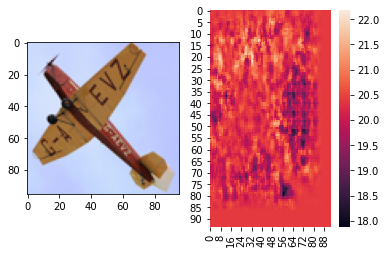

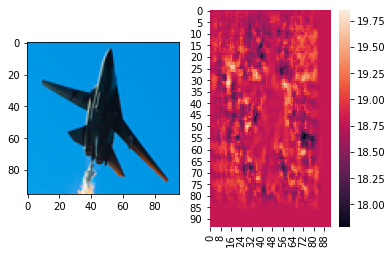

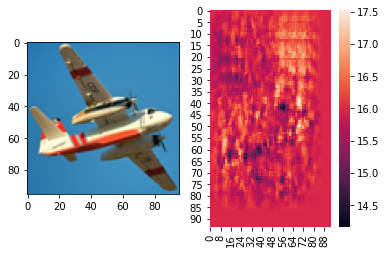

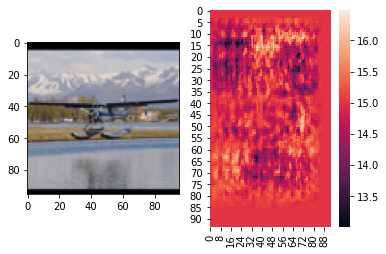

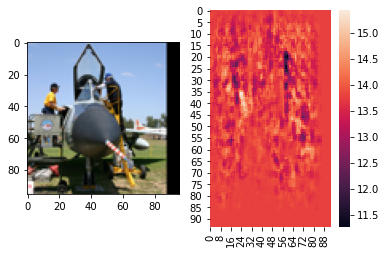

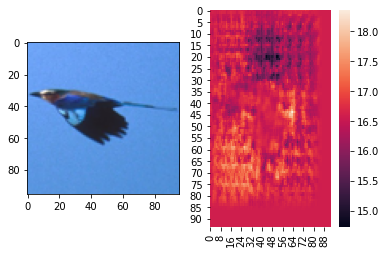

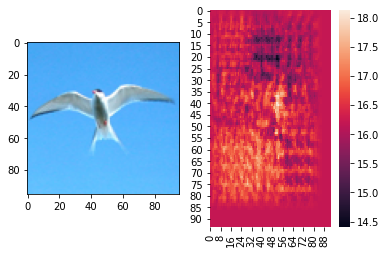

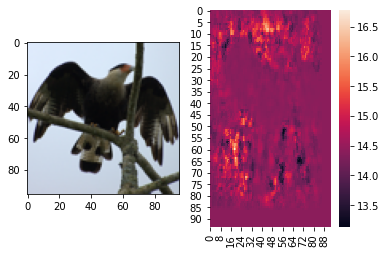

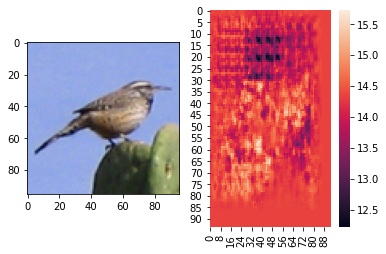

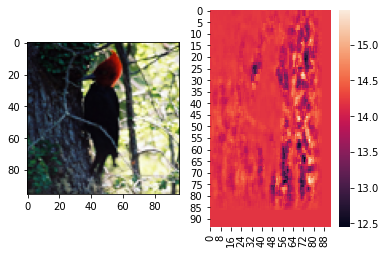

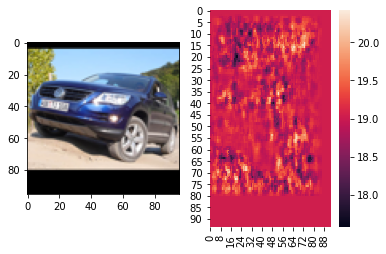

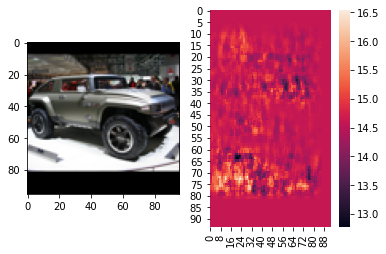

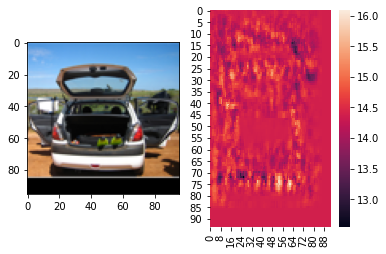

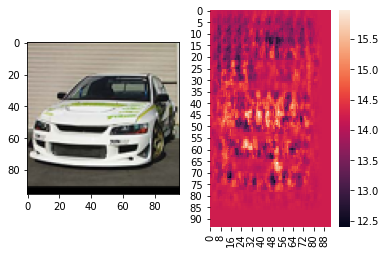

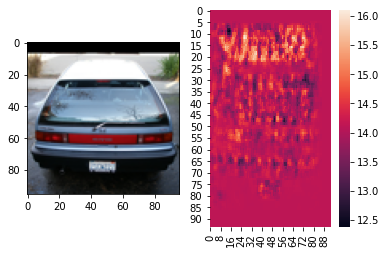

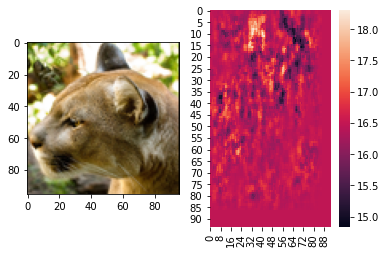

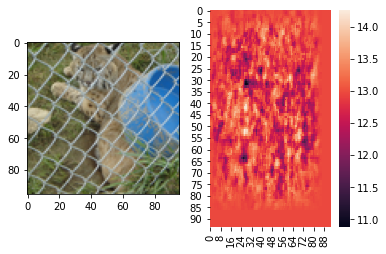

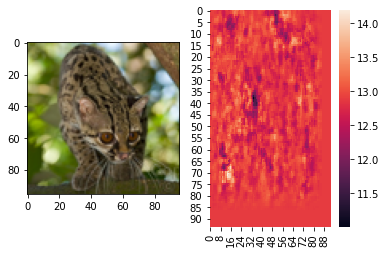

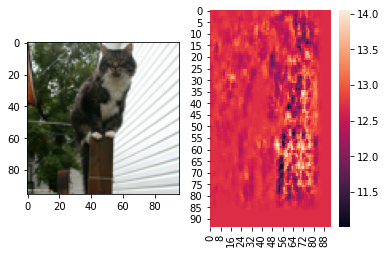

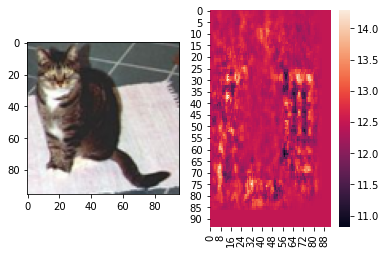

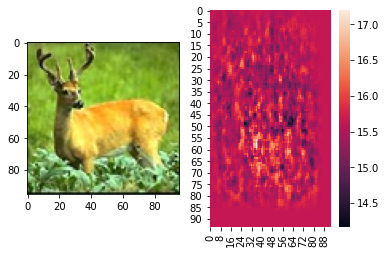

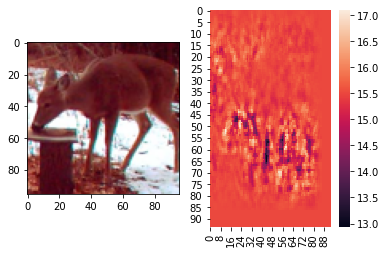

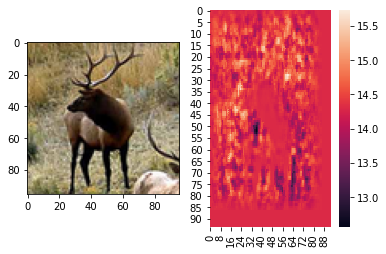

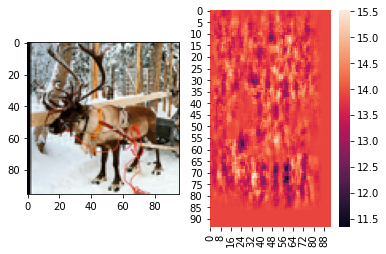

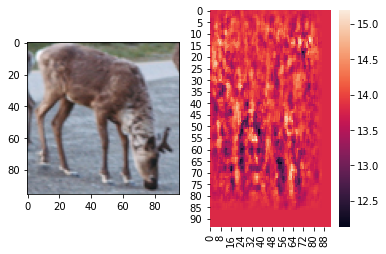

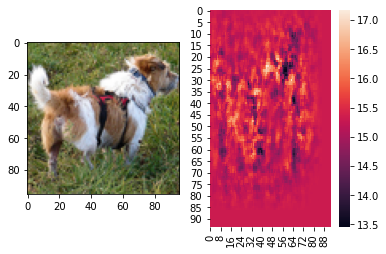

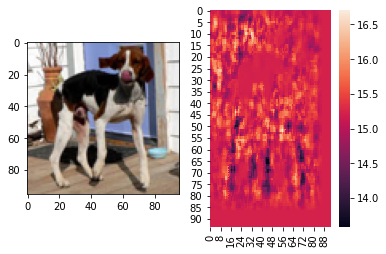

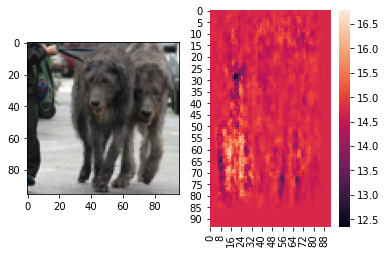

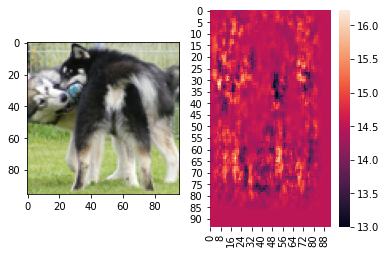

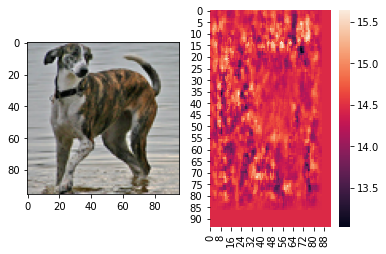

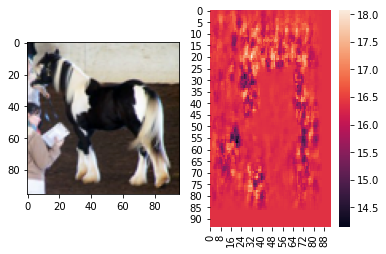

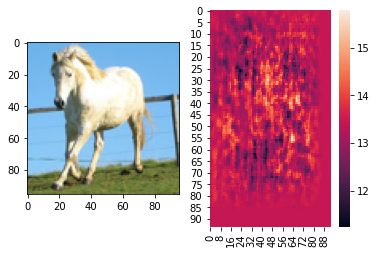

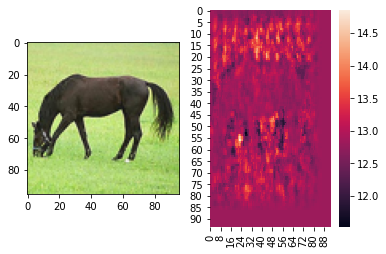

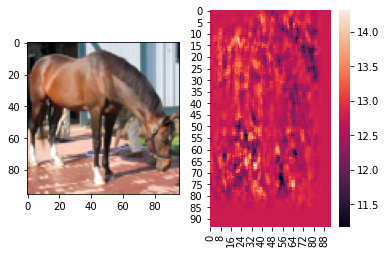

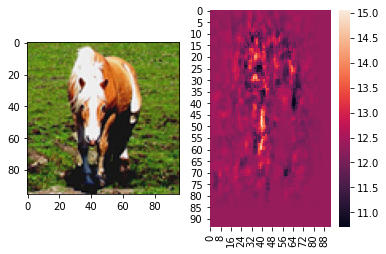

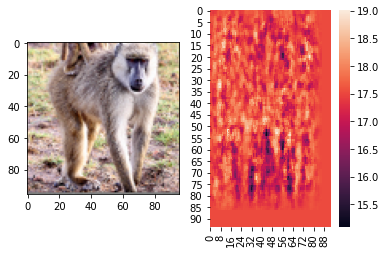

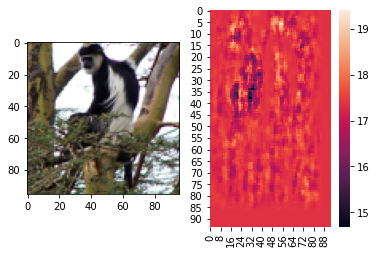

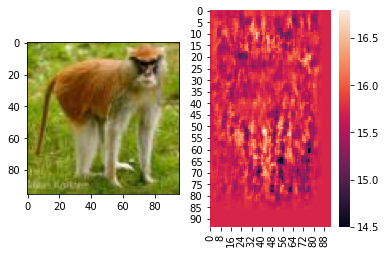

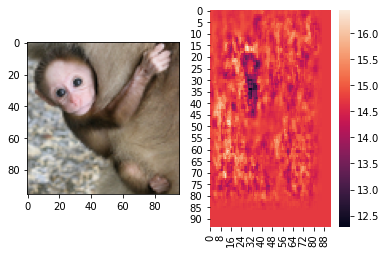

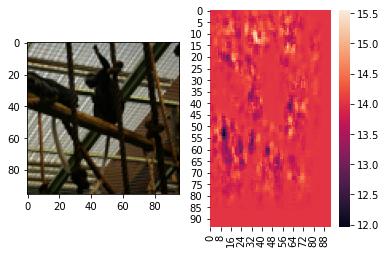

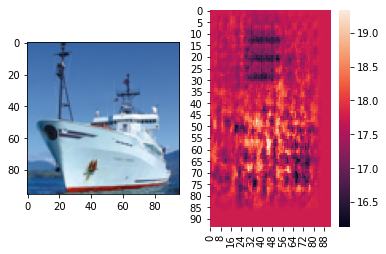

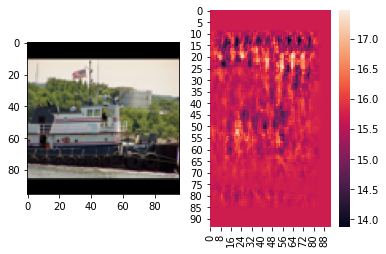

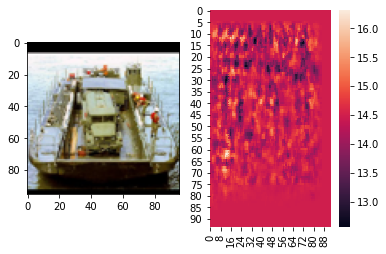

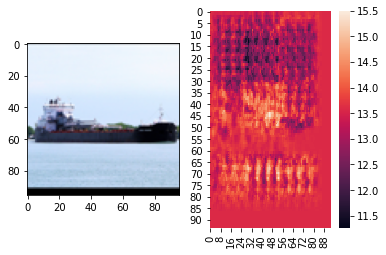

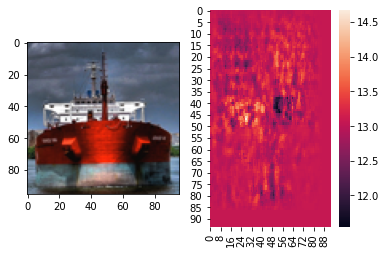

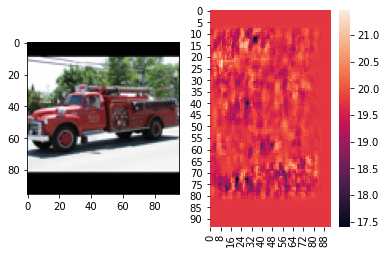

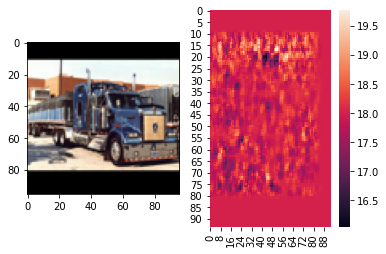

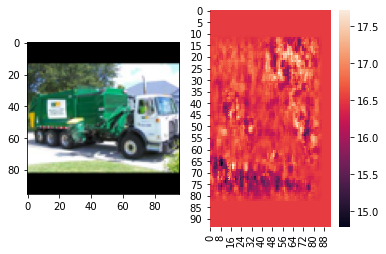

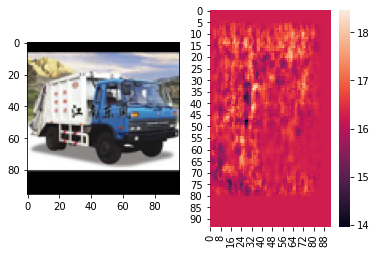

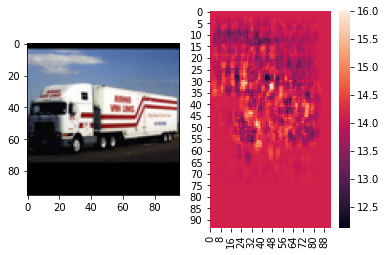

In [286]:
def OcS(img):
    img = img.numpy()
    sm = np.zeros((img.shape[1]-2,img.shape[2]-2))
    for i in range(img.shape[1]-2):
        for j in  range(img.shape[2]-2):
            
            image = img.copy()
            
            image[:,i:i+3,j:j+3] = 0
            image = torch.from_numpy(image)
            image = image.unsqueeze(0)
           
            outputs = net1(image)
            score, predicted = torch.max(outputs, 1)
            sm[i,j] = score
    
    return sm
    
import seaborn as sns

for i in range(10):
    arr = np.array(c1[i])
    top_k_idx=arr.argsort()[::-1][0:5]
    for x in range(len(top_k_idx)):
        plt.figure()
        plt.subplot(1,2,1)
        img = np.moveaxis(im1[i][top_k_idx[x]].numpy(),0,2)
        plt.imshow(img/255)
        plt.subplot(1,2,2)
        sm = OcS(im1[i][top_k_idx[x]])
        sns.heatmap(data=sm)
        plt.show()

0


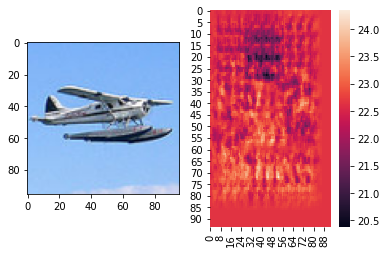

1


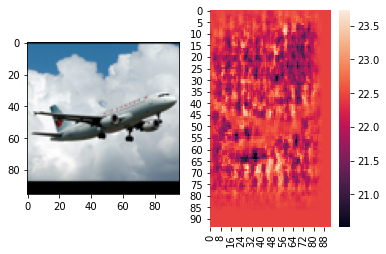

2


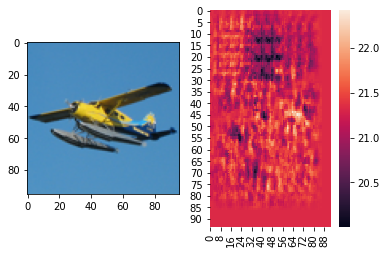

3


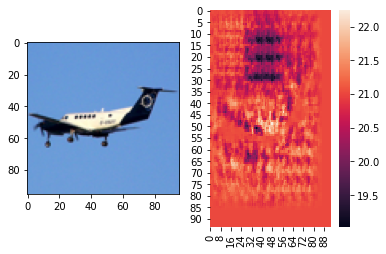

4


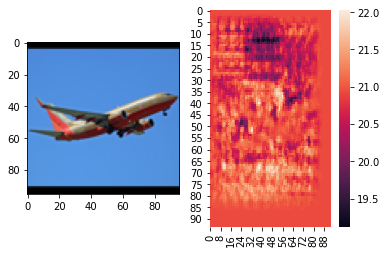

5


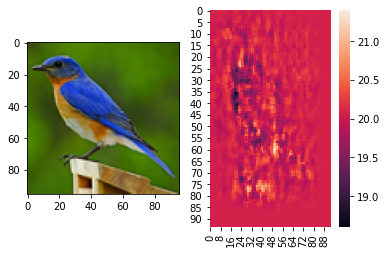

6


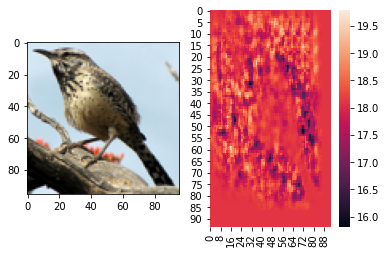

7


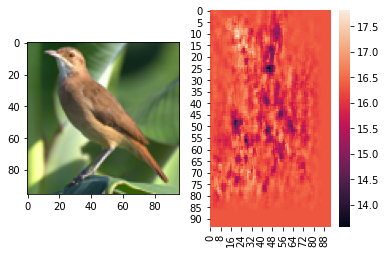

8


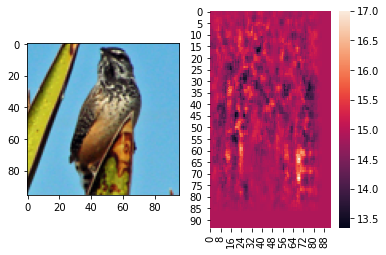

9


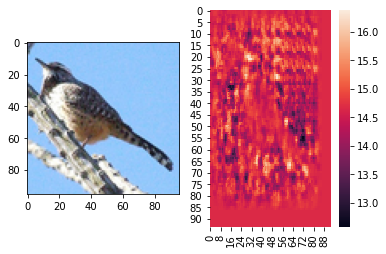

10


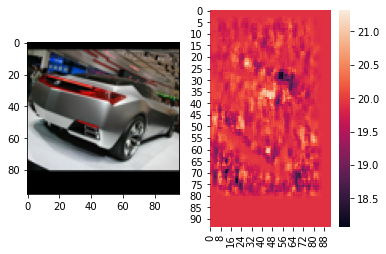

11


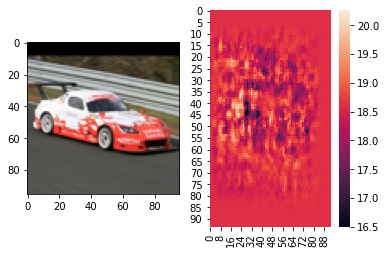

12


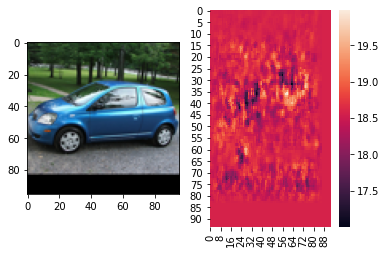

13


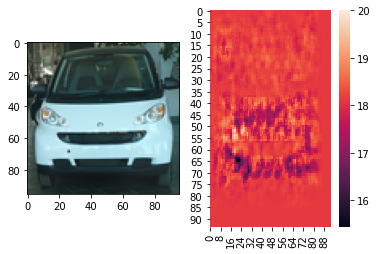

14


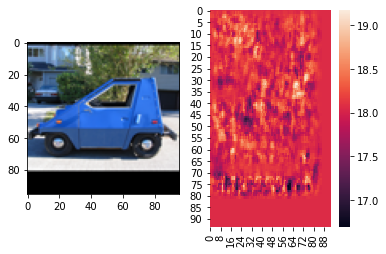

15


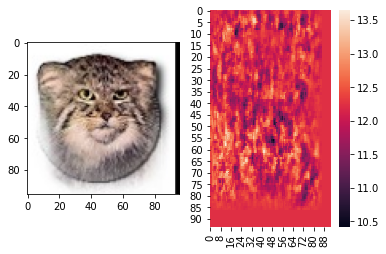

16


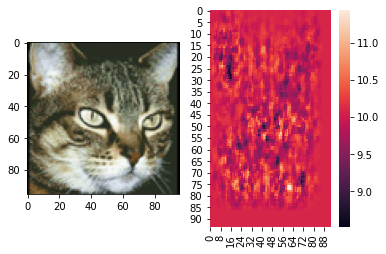

17


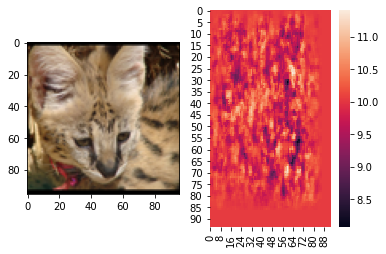

18


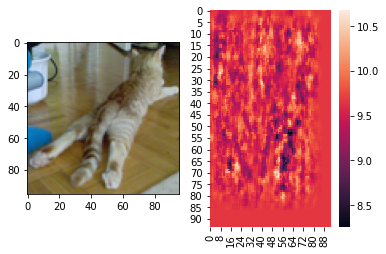

19


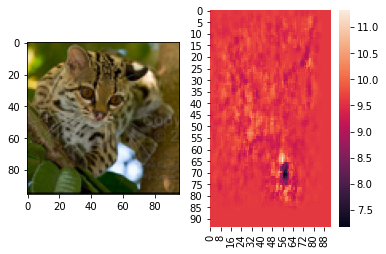

20


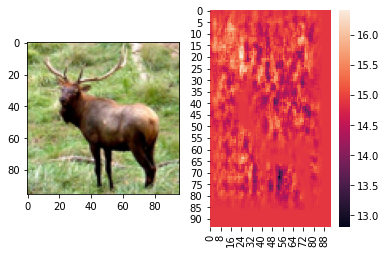

21


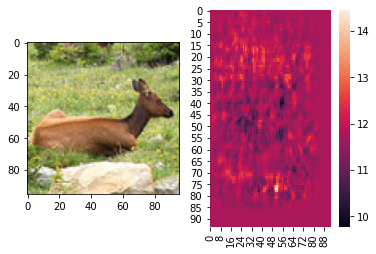

22


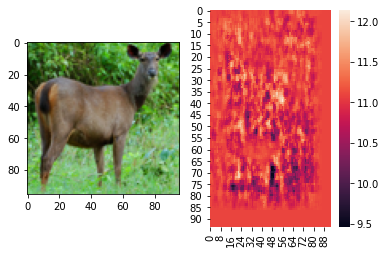

23


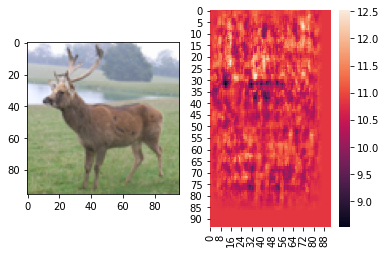

24


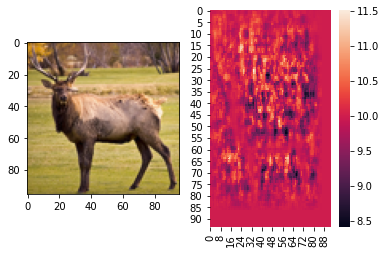

25


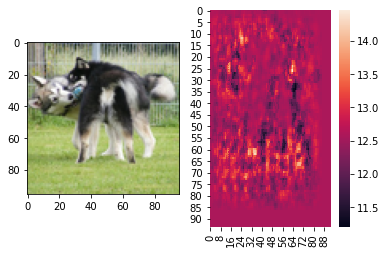

26


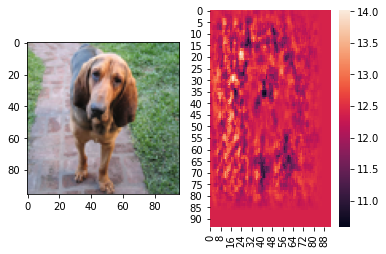

27


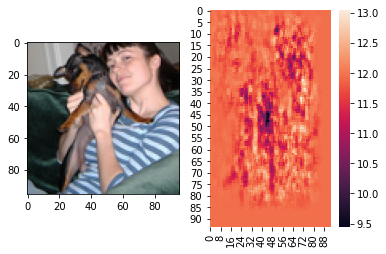

28


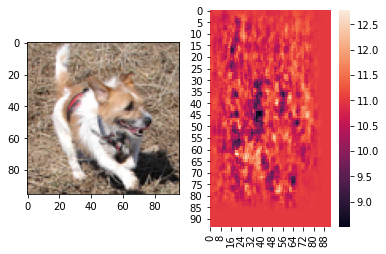

29


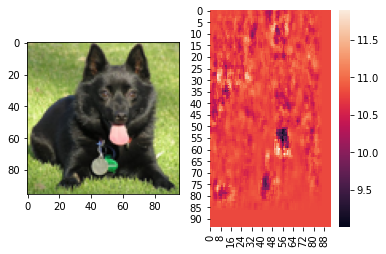

30


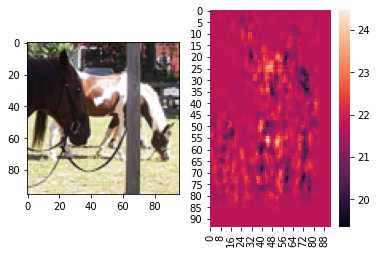

31


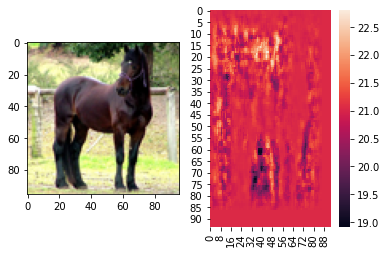

32


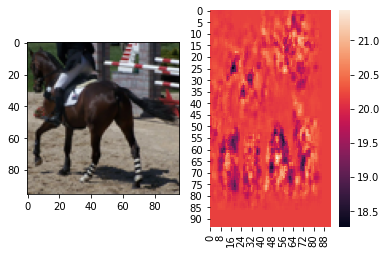

33


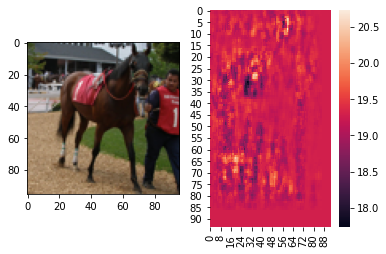

34


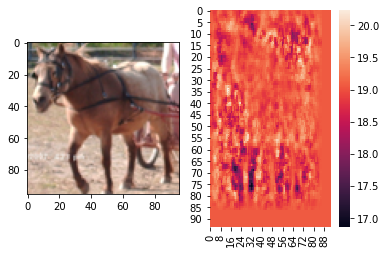

35


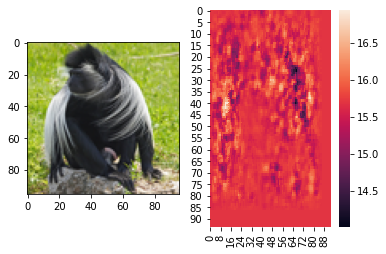

36


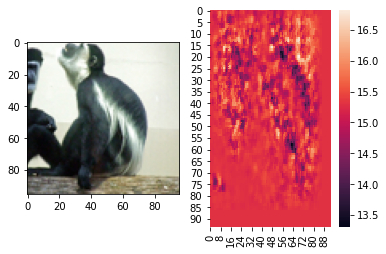

37


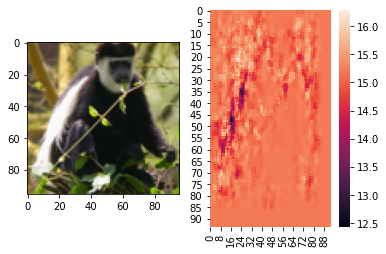

38


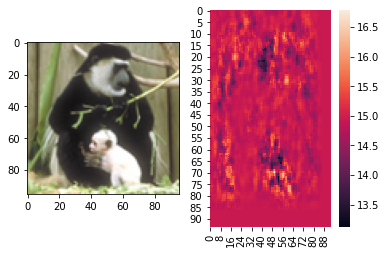

39


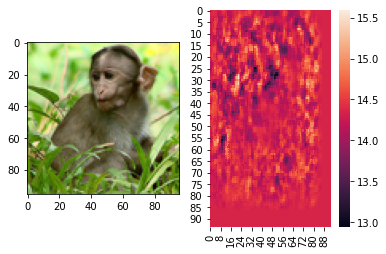

40


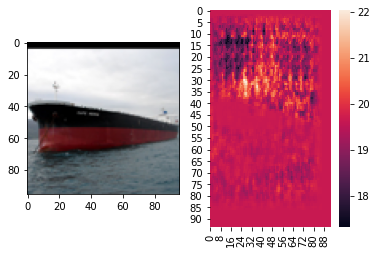

41


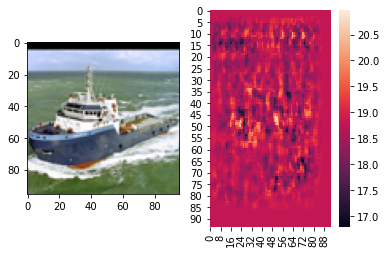

42


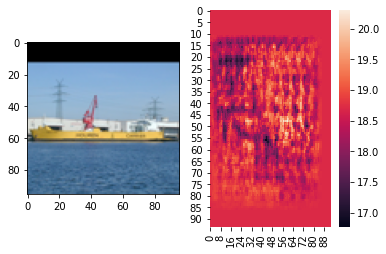

43


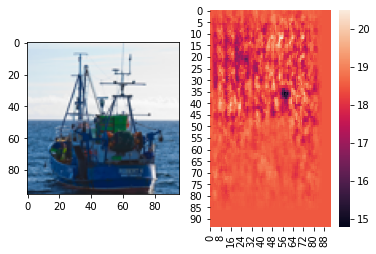

44


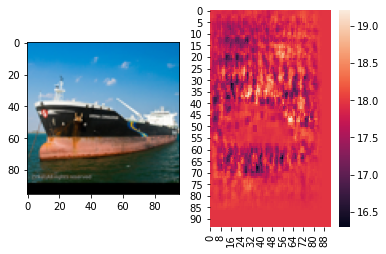

45


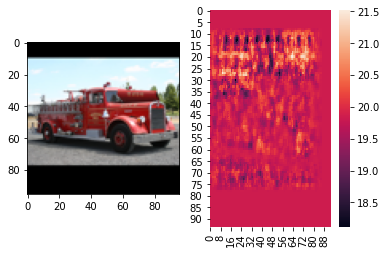

46


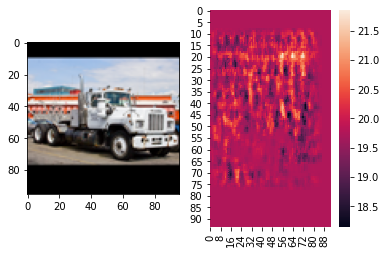

47


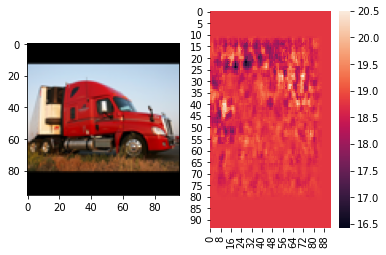

48


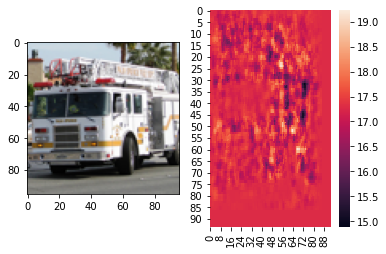

49


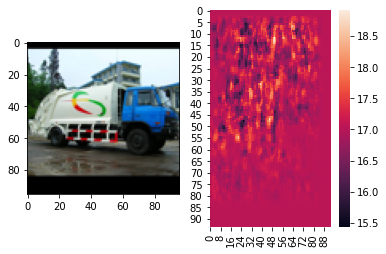

In [289]:
for i in range(10):
    arr = np.array(c[i])
    top_k_idx=arr.argsort()[::-1][0:5]
    for x in range(len(top_k_idx)):
        print(i*5+x)
        plt.figure()
        plt.subplot(1,2,1)
        img = np.moveaxis(im[i][top_k_idx[x]].numpy(),0,2)
        plt.imshow(img/255)
        plt.subplot(1,2,2)
        sm = OcS(im[i][top_k_idx[x]])
        sns.heatmap(data=sm)
        plt.show()